In [2]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.models as models
import os
import re

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
device

device(type='cuda')

In [3]:
batch_size = 32
num_epochs = 10
learning_rate = 1e-3

# **utils**

In [3]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3,
        figsize=(8, 6),
        sharey=True,
        sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose(1, 2, 0))

In [4]:
def get_model(model_name, num_classes, ngpu = 2, requires_grad=False):
    if model_name == "resnet18":
        model = models.resnet18(weights="DEFAULT")
        model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(weights="DEFAULT")
        model.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "inception_v3":
        model = models.inception_v3(weights="DEFAULT", aux_logits=True)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, bias=False)

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.fc.parameters():
            param.requires_grad = True

        for param in model.AuxLogits.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    elif model_name == "densenet161":
        model = models.densenet161(weights="DEFAULT")
        model.features.conv0 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, bias=False)

        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights="DEFAULT")

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.classifier.parameters():
            param.requires_grad = True

        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    model = model.to(device)
    if torch.cuda.device_count() > ngpu:
        print(f"Using {torch.cuda.device_count()} GPUs for {model_name}")
        model = nn.DataParallel(model)

    return model

In [5]:
def train_model(
        model, 
        train_loader, 
        val_loader, 
        num_epochs, 
        model_name, 
        criterion=nn.CrossEntropyLoss(),
        optimizer_type="Adam",
        lr=learning_rate, 
        scheduler_type="StepLR",
        optimizer_params=None
):
    optimizer_params = optimizer_params or {}
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4, **optimizer_params)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, **optimizer_params)
    elif optimizer_type == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4, **optimizer_params)

    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=3, gamma=.1)
    elif scheduler_type == "CosineAnnealingLR":
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # total_steps = len(train_loader)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        start = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            if model_name == "inception_v3" and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # if i % (total_steps // 2) == 0:
            #     print(f"Step {i}. Time since epoch: {time.time() - start:.3f}.")
        
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)
        
        scheduler.step()

        clear_output()
        
        print(f'Time {time.time() - start:.3f} sec, {model_name} Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# **Dataset**

In [6]:
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

# **Transformations**

In [7]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_transforms_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

train_transforms_significant = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5),
    transforms.RandomAffine(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-45, 45)),
    transforms.ToTensor(),
])

# **Prepairing datasets**

In [8]:
train_dataset_base = tv.datasets.ImageFolder(
    root=os.path.join(path, 'simpsons_dataset/simpsons_dataset'),
    transform=train_transforms_base
)

train_dataset_significant = tv.datasets.ImageFolder(
    root=os.path.join(path, 'simpsons_dataset/simpsons_dataset'),
    transform=train_transforms_significant
)

val_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'simpsons_dataset/simpsons_dataset'),
    transform=val_transforms
)

num_classes = len(train_dataset_base.classes)

# **Splitting samples**

In [10]:
train_indices, val_indices = train_test_split(
    list(range(train_dataset_base.__len__())), 
    test_size=.3, 
    stratify=train_dataset_base.targets, 
    random_state=42
)

In [10]:
train_dataset_base.__len__(), len(train_indices), len(val_indices)

(20933, 14653, 6280)

# **Creation loaders**

In [11]:
train_dataset_base = Subset(train_dataset_base, train_indices)
train_dataset_significant = Subset(train_dataset_significant, train_indices)
val_dataset = Subset(val_dataset, val_indices)

train_loader_base = DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True)
train_loader_significant = DataLoader(train_dataset_significant, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
len(train_dataset_base.dataset.classes), len(val_dataset.dataset.classes), len(train_dataset_significant.dataset.classes)

(42, 42, 42)

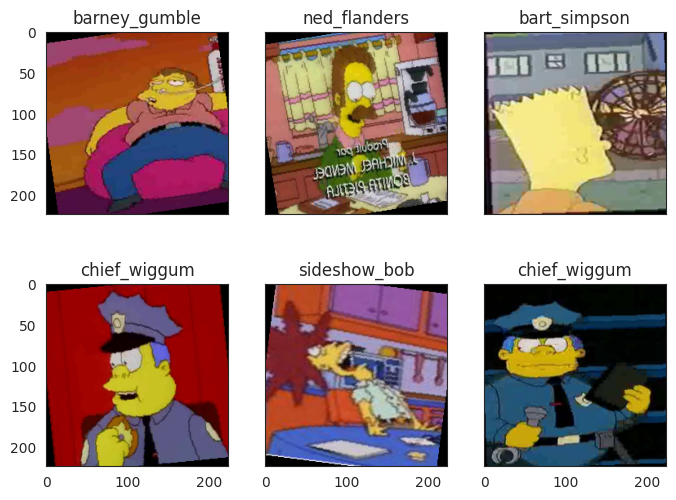

In [13]:
show_images(train_dataset_base.dataset)

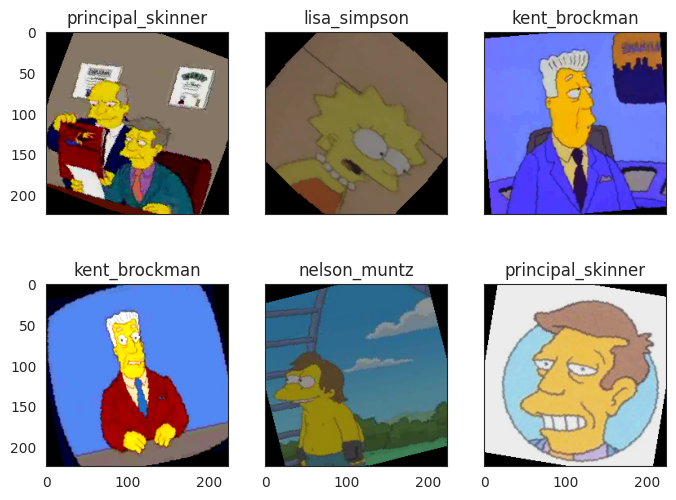

In [14]:
show_images(train_dataset_significant.dataset)

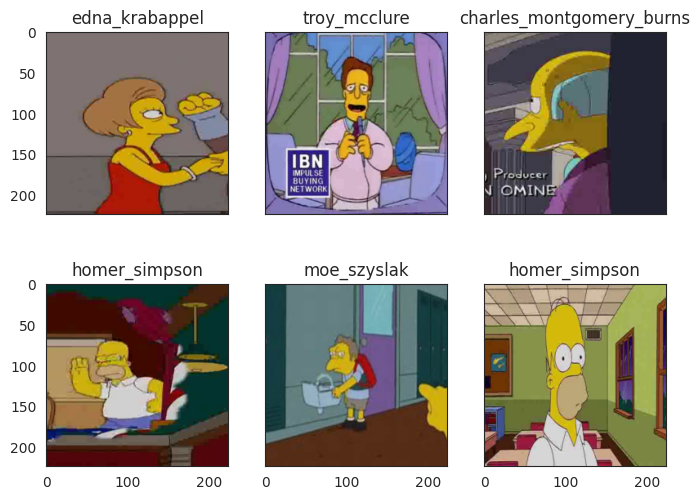

In [15]:
show_images(val_dataset.dataset)

# **Experiments with training only classifier in model with base and significant augmentations**

In [ ]:
model_name = 'efficientnet_b0'

# Эксперимент 1: StepLR с базовыми аугментациями
model1 = get_model(model_name, num_classes, requires_grad=False)
print("Эксперимент 1: StepLR с базовыми аугментациями")
train_losses1, val_losses1, train_acc1, val_acc1 = train_model(
    model=model1, train_loader=train_loader_base, val_loader=val_loader, scheduler_type="StepLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Эксперимент 2: CosineAnnealingLR с базовыми аугментациями
model2 = get_model(model_name, num_classes, requires_grad=False)
print("\nЭксперимент 2: CosineAnnealingLR с базовыми аугментациями")
train_losses2, val_losses2, train_acc2, val_acc2 = train_model(
    model=model2, train_loader=train_loader_base, val_loader=val_loader, scheduler_type="CosineAnnealingLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Эксперимент 3: StepLR со значительными аугментациями
model3 = get_model(model_name, num_classes, requires_grad=False)
print("\nЭксперимент 3: StepLR со значительными аугментациями")
train_losses3, val_losses3, train_acc3, val_acc3 = train_model(
    model=model3, train_loader=train_loader_significant, val_loader=val_loader, scheduler_type="StepLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Эксперимент 4: StepLR со значительными аугментациями
model4 = get_model(model_name, num_classes, requires_grad=False)
print("\nЭксперимент 4: CosineAnnealingLR со значительными аугментациями")
train_losses4, val_losses4, train_acc4, val_acc4 = train_model(
    model=model4, train_loader=train_loader_significant, val_loader=val_loader, scheduler_type="CosineAnnealingLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Time 77.282 sec, efficientnet_b0 Epoch [10/10], Train Loss: 1.4942, Train Acc: 58.31%, Val Loss: 1.6950, Val Acc: 54.70%


# **Creation model with training 2 last blocks and handmade classifier**

In [13]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module("base_model", models.efficientnet_b0(weights="DEFAULT"))

# Заморозка всех слоев базовой модели
for param in fine_tuning_model.base_model.parameters():
    param.requires_grad = False

# Разморозка последних 2 блоков базовой модели
for param in fine_tuning_model.base_model.features[7:].parameters():
    param.requires_grad = True

# Замена классификатора
fine_tuning_model.base_model.classifier = nn.Sequential(
    nn.ReLU(),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

fine_tuning_model = fine_tuning_model.to(device)

# **Experiments with training 2 last blocks and handmade classifier in model with significant augmentations**

In [21]:
# Эксперимент 5: StepLR со значительными аугментациями
print("\nЭксперимент 5: StepLR со значительными аугментациями")
train_losses5, val_losses5, train_acc5, val_acc5 = train_model(
    model=fine_tuning_model, train_loader=train_loader_significant, val_loader=val_loader, scheduler_type="StepLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Эксперимент 6: CosineAnnealingLR со значительными аугментациями
print("\nЭксперимент 6: CosineAnnealingLR со значительными аугментациями")
train_losses6, val_losses6, train_acc6, val_acc6 = train_model(
    model=fine_tuning_model, train_loader=train_loader_significant, val_loader=val_loader, scheduler_type="CosineAnnealingLR", model_name=model_name, num_epochs=num_epochs
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Time 77.677 sec, efficientnet_b0 Epoch [10/10], Train Loss: 0.1559, Train Acc: 95.44%, Val Loss: 0.2437, Val Acc: 94.20%


# **Vizualisation results**

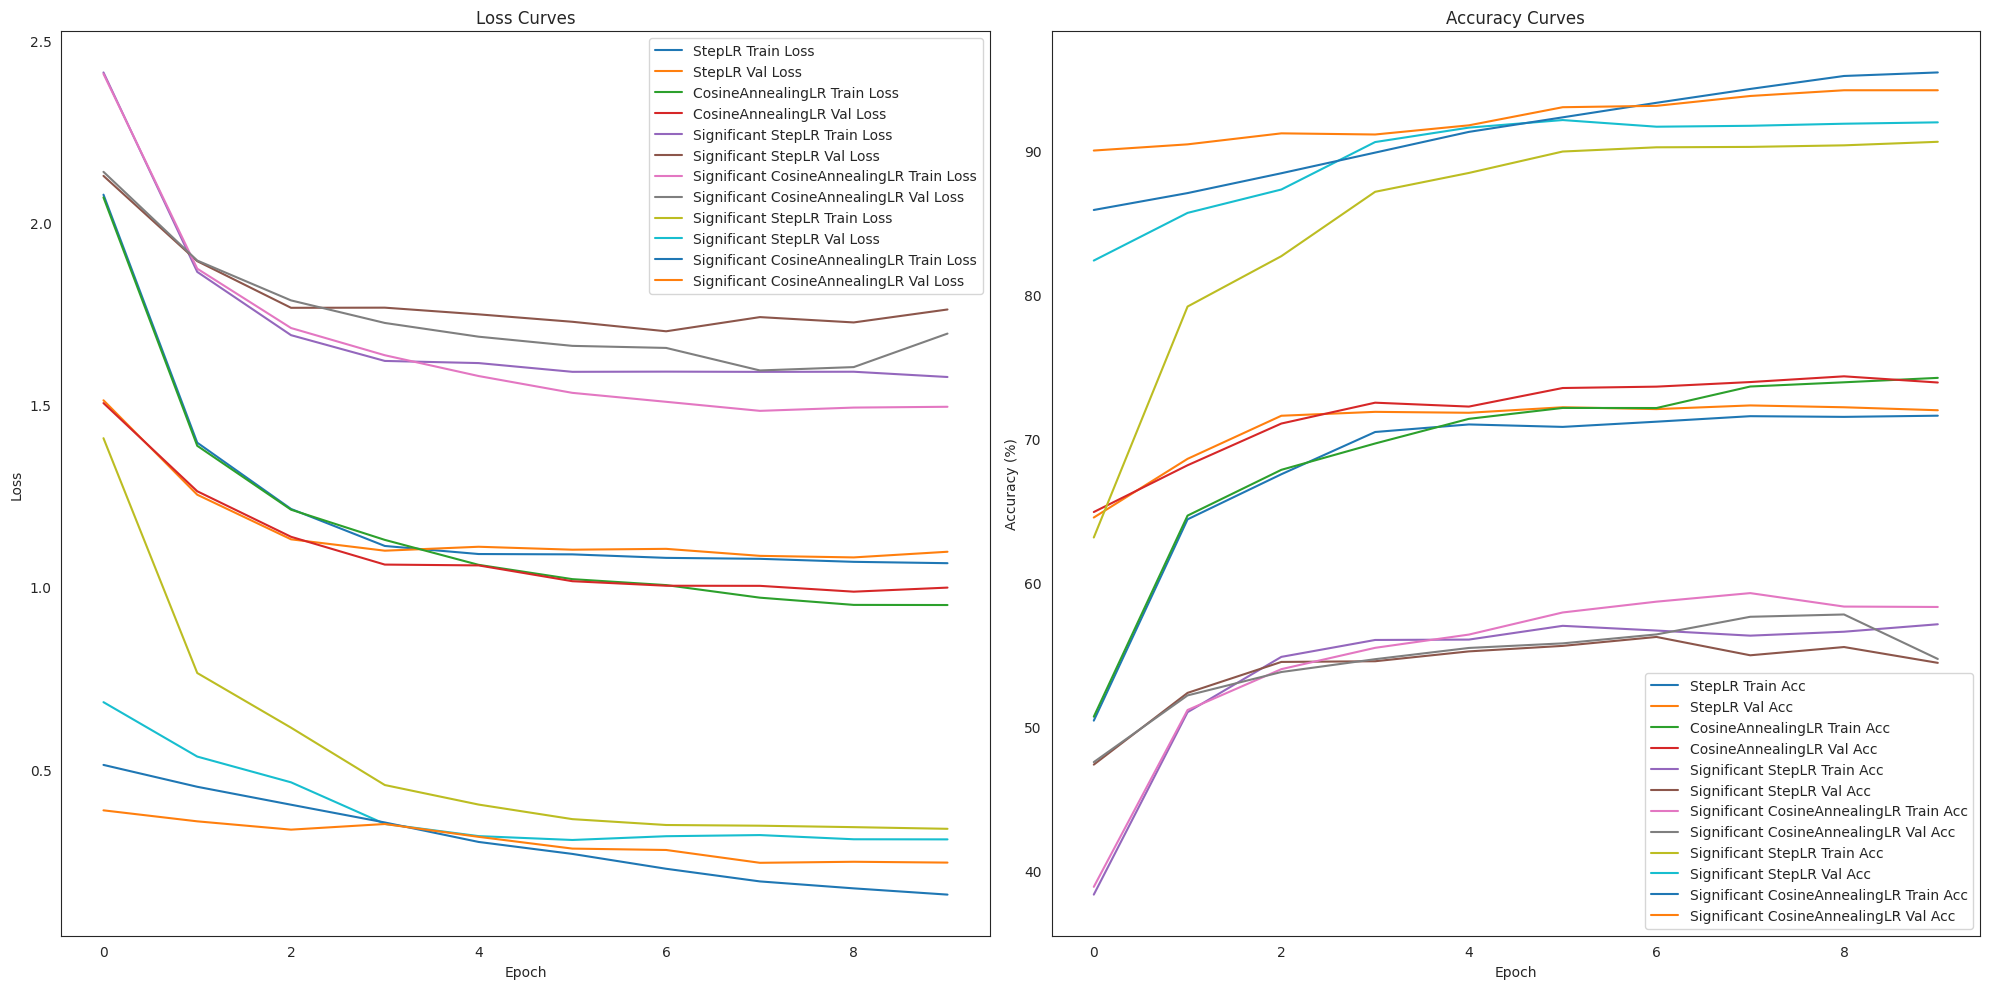

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_losses1, label="StepLR Train Loss")
plt.plot(val_losses1, label="StepLR Val Loss")
plt.plot(train_losses2, label="CosineAnnealingLR Train Loss")
plt.plot(val_losses2, label="CosineAnnealingLR Val Loss")
plt.plot(train_losses3, label="Significant StepLR Train Loss")
plt.plot(val_losses3, label="Significant StepLR Val Loss")
plt.plot(train_losses4, label="Significant CosineAnnealingLR Train Loss")
plt.plot(val_losses4, label="Significant CosineAnnealingLR Val Loss")
plt.plot(train_losses5, label="Significant StepLR Train Loss")
plt.plot(val_losses5, label="Significant StepLR Val Loss")
plt.plot(train_losses6, label="Significant CosineAnnealingLR Train Loss")
plt.plot(val_losses6, label="Significant CosineAnnealingLR Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc1, label="StepLR Train Acc")
plt.plot(val_acc1, label="StepLR Val Acc")
plt.plot(train_acc2, label="CosineAnnealingLR Train Acc")
plt.plot(val_acc2, label="CosineAnnealingLR Val Acc")
plt.plot(train_acc3, label="Significant StepLR Train Acc")
plt.plot(val_acc3, label="Significant StepLR Val Acc")
plt.plot(train_acc4, label="Significant CosineAnnealingLR Train Acc")
plt.plot(val_acc4, label="Significant CosineAnnealingLR Val Acc")
plt.plot(train_acc5, label="Significant StepLR Train Acc")
plt.plot(val_acc5, label="Significant StepLR Val Acc")
plt.plot(train_acc6, label="Significant CosineAnnealingLR Train Acc")
plt.plot(val_acc6, label="Significant CosineAnnealingLR Val Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# **Creation table of results**

In [33]:
pd.DataFrame(
    {
        "Epoch": np.arange(1, num_epochs + 1),
        "StepLR Train Loss (only classifier)": [round(i, 3) for i in train_losses1],
        "StepLR Val Loss (only classifier)": [round(i, 3) for i in val_losses1],
        "CosineAnnealingLR Train Loss (only classifier)": [round(i, 3) for i in train_losses2],
        "CosineAnnealingLR Val Loss (only classifier)": [round(i, 3) for i in val_losses2],
        "Significant StepLR Train Loss (only classifier)": [round(i, 3) for i in train_losses3],
        "Significant StepLR Val Loss (only classifier)": [round(i, 3) for i in val_losses3],
        "Significant CosineAnnealingLR Train Loss (only classifier)": [round(i, 3) for i in train_losses4],
        "Significant CosineAnnealingLR Val Loss (only classifier)": [round(i, 3) for i in val_losses4],
        "Significant StepLR Train Loss (handmade classifier and 2 last blocks)": [round(i, 3) for i in train_losses5],
        "Significant StepLR Val Loss (handmade classifier and 2 last blocks)": [round(i, 3) for i in val_losses5],
        "Significant CosineAnnealingLR Train Loss (handmade classifier and 2 last blocks)": [round(i, 3) for i in train_losses6],
        "Significant CosineAnnealingLR Val Loss (handmade classifier and 2 last blocks)": [round(i, 3) for i in val_losses6],
    }
)

,Epoch,StepLR Train Loss (only classifier),StepLR Val Loss (only classifier),CosineAnnealingLR Train Loss (only classifier),CosineAnnealingLR Val Loss (only classifier),Significant StepLR Train Loss (only classifier),Significant StepLR Val Loss (only classifier),Significant CosineAnnealingLR Train Loss (only classifier),Significant CosineAnnealingLR Val Loss (only classifier),Significant StepLR Train Loss (handmade classifier and 2 last blocks),Significant StepLR Val Loss (handmade classifier and 2 last blocks),Significant CosineAnnealingLR Train Loss (handmade classifier and 2 last blocks),Significant CosineAnnealingLR Val Loss (handmade classifier and 2 last blocks)
0,1,2.076,1.512,2.069,1.504,2.411,2.128,2.408,2.139,1.408,0.684,0.512,0.387
1,2,1.396,1.253,1.387,1.262,1.864,1.894,1.873,1.895,0.764,0.535,0.452,0.357
2,3,1.214,1.131,1.212,1.137,1.691,1.766,1.710,1.786,0.614,0.464,0.402,0.334
3,4,1.112,1.099,1.129,1.061,1.620,1.766,1.636,1.724,0.456,0.350,0.354,0.350
4,5,1.090,1.110,1.061,1.059,1.614,1.748,1.579,1.686,0.403,0.316,0.300,0.314
5,6,1.089,1.102,1.021,1.016,1.590,1.727,1.532,1.661,0.363,0.306,0.267,0.282
6,7,1.080,1.104,1.005,1.003,1.591,1.701,1.508,1.656,0.347,0.316,0.227,0.278
7,8,1.077,1.085,0.970,1.003,1.590,1.740,1.483,1.594,0.345,0.319,0.192,0.243
8,9,1.069,1.081,0.951,0.987,1.590,1.726,1.492,1.603,0.341,0.308,0.173,0.246
9,10,1.065,1.096,0.950,0.998,1.576,1.761,1.494,1.695,0.336,0.307,0.156,0.244


# **Creation test dataset**

In [32]:
pd.DataFrame(
    {
        "Epoch": np.arange(1, num_epochs + 1),
        "StepLR Train Acc (only classifier)": [round(i, 2) for i in train_acc1],
        "StepLR Val Acc (only classifier)": [round(i, 2) for i in val_acc1],
        "CosineAnnealingLR Train Acc (only classifier)": [round(i, 2) for i in train_acc2],
        "CosineAnnealingLR Val Acc (only classifier)": [round(i, 2) for i in val_acc2],
        "Significant StepLR Train Acc (only classifier)": [round(i, 2) for i in train_acc3],
        "Significant StepLR Val Acc (only classifier)": [round(i, 2) for i in val_acc3],
        "Significant CosineAnnealingLR Train Acc (only classifier)": [round(i, 2) for i in train_acc4],
        "Significant CosineAnnealingLR Val Acc (only classifier)": [round(i, 2) for i in val_acc4],
        "Significant StepLR Train Acc (handmade classifier and 2 last blocks)": [round(i, 2) for i in train_acc5],
        "Significant StepLR Val Acc (handmade classifier and 2 last blocks)": [round(i, 2) for i in val_acc5],
        "Significant CosineAnnealingLR Train Acc (handmade classifier and 2 last blocks)": [round(i, 2) for i in train_acc6],
        "Significant CosineAnnealingLR Val Acc (handmade classifier and 2 last blocks)": [round(i, 2) for i in val_acc6],
    }
)

,Epoch,StepLR Train Acc (only classifier),StepLR Val Acc (only classifier),CosineAnnealingLR Train Acc (only classifier),CosineAnnealingLR Val Acc (only classifier),Significant StepLR Train Acc (only classifier),Significant StepLR Val Acc (only classifier),Significant CosineAnnealingLR Train Acc (only classifier),Significant CosineAnnealingLR Val Acc (only classifier),Significant StepLR Train Acc (handmade classifier and 2 last blocks),Significant StepLR Val Acc (handmade classifier and 2 last blocks),Significant CosineAnnealingLR Train Acc (handmade classifier and 2 last blocks),Significant CosineAnnealingLR Val Acc (handmade classifier and 2 last blocks)
0,1,50.41,64.52,50.69,64.90,38.33,47.36,38.87,47.53,63.13,82.37,85.89,90.02
1,2,64.40,68.60,64.66,68.15,51.00,52.34,51.15,52.17,79.18,85.68,87.06,90.45
2,3,67.53,71.59,67.84,71.05,54.84,54.49,53.99,53.79,82.68,87.31,88.44,91.21
3,4,70.46,71.86,69.66,72.50,56.02,54.54,55.47,54.68,87.15,90.61,89.87,91.13
4,5,70.99,71.80,71.38,72.23,56.04,55.22,56.39,55.46,88.46,91.61,91.31,91.77
5,6,70.82,72.18,72.14,73.52,57.00,55.61,57.93,55.78,89.95,92.13,92.32,93.03
6,7,71.18,72.05,72.13,73.61,56.67,56.23,58.68,56.40,90.24,91.67,93.33,93.12
7,8,71.56,72.31,73.62,73.93,56.32,54.95,59.27,57.63,90.27,91.74,94.29,93.81
8,9,71.51,72.18,73.92,74.33,56.59,55.53,58.34,57.79,90.38,91.88,95.20,94.20
9,10,71.60,71.97,74.22,73.90,57.11,54.43,58.31,54.70,90.62,91.97,95.44,94.20


In [24]:
test_dataset_base = tv.datasets.ImageFolder(
    root=os.path.join(path, 'kaggle_simpson_testset'),
    transform=val_transforms
)

test_dataset_base = DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False)

# **Getting class names**

In [25]:
class_names = {v: k for k, v in train_dataset_significant.dataset.class_to_idx.items()}
class_names

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lionel_hutz',
 20: 'lisa_simpson',
 21: 'maggie_simpson',
 22: 'marge_simpson',
 23: 'martin_prince',
 24: 'mayor_quimby',
 25: 'milhouse_van_houten',
 26: 'miss_hoover',
 27: 'moe_szyslak',
 28: 'ned_flanders',
 29: 'nelson_muntz',
 30: 'otto_mann',
 31: 'patty_bouvier',
 32: 'principal_skinner',
 33: 'professor_john_frink',
 34: 'rainier_wolfcastle',
 35: 'ralph_wiggum',
 36: 'selma_bouvier',
 37: 'sideshow_bob',
 38: 'sideshow_mel',
 39: 'snake_jailbird',
 40: 'troy_mcclure',
 41: 'waylon_smithers'}

# **Visualisation test data predictions**

In [39]:
def visualize_predictions(model, data_loader, class_names, device, num_images=10, figsize=(20, 7)):
    model.eval()
    
    all_images = []
    all_labels = []
    all_file_paths = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data_loader):
            all_images.append(images)
            all_labels.append(labels)
            
            start_idx = batch_idx * data_loader.batch_size
            end_idx = min(start_idx + data_loader.batch_size, len(data_loader.dataset))
            batch_paths = [data_loader.dataset.samples[i][0] for i in range(start_idx, end_idx)]
            all_file_paths.extend(batch_paths)
    
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    total_images = len(all_images)
    indices = np.random.choice(total_images, size=min(num_images, total_images), replace=False)
    
    images = all_images[indices].to(device)
    labels = all_labels[indices].to(device)
    selected_file_paths = [all_file_paths[i] for i in indices]
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
    
    results = []
    
    for i in range(len(indices)):        
        file_name = os.path.basename(selected_file_paths[i])
        true_label_from_file = re.sub(r'_\d+\.jpg$', '', file_name)
        pred_label_idx = predicted[i].item()
        pred_label = class_names[pred_label_idx]
        is_correct = (true_label_from_file == pred_label)
        pred_prob = probabilities[i][pred_label_idx].cpu().numpy()
        
        results.append({
            'file_name': file_name,
            'true_label': true_label_from_file,
            'predicted_label': pred_label,
            'is_correct': is_correct,
            'predicted_probability': round(float(pred_prob), 3)
        })
    
    ncols = 5
    nrows = num_images // ncols + 1

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    axes = axes.ravel()
    
    for i in range(len(indices)):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        file_name = results[i]['file_name']
        true_label = results[i]['true_label']
        pred_label = results[i]['predicted_label']
        pred_prob = results[i]['predicted_probability']
        is_correct = results[i]['is_correct']
        
        axes[i].imshow(img)
        axes[i].set_title(
            f"File: {file_name}\nTrue: {true_label}\nPredicted: {pred_label}\n"
            f"P({pred_label}): {pred_prob:.3f}",
            fontsize=10
        )
        axes[i].axis('off')
    
    for j in range(len(indices), len(axes)):
        axes[j].axis('off')
    
    plt.show()
    
    return [
        (r['file_name'], r['predicted_label'], r['is_correct'], r['predicted_probability'])
        for r in results
    ]

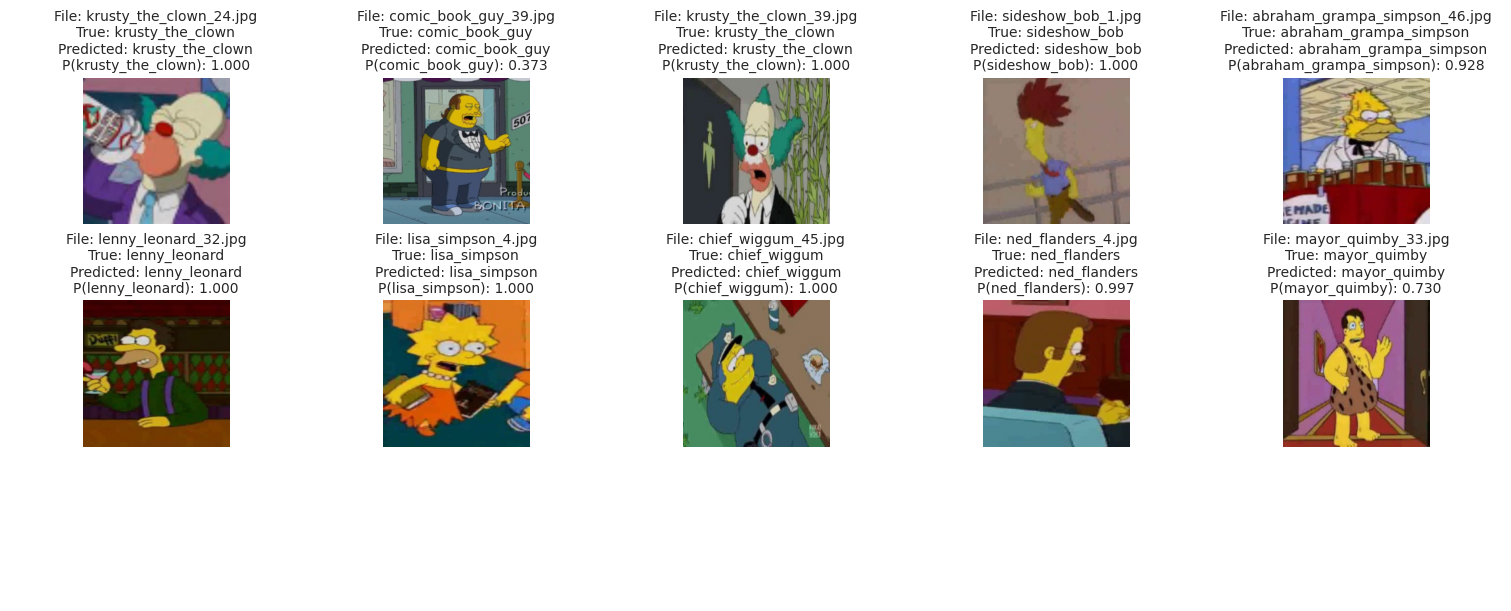

[('krusty_the_clown_24.jpg', 'krusty_the_clown', True, 1.0),
 ('comic_book_guy_39.jpg', 'comic_book_guy', True, 0.373),
 ('krusty_the_clown_39.jpg', 'krusty_the_clown', True, 1.0),
 ('sideshow_bob_1.jpg', 'sideshow_bob', True, 1.0),
 ('abraham_grampa_simpson_46.jpg', 'abraham_grampa_simpson', True, 0.928),
 ('lenny_leonard_32.jpg', 'lenny_leonard', True, 1.0),
 ('lisa_simpson_4.jpg', 'lisa_simpson', True, 1.0),
 ('chief_wiggum_45.jpg', 'chief_wiggum', True, 1.0),
 ('ned_flanders_4.jpg', 'ned_flanders', True, 0.997),
 ('mayor_quimby_33.jpg', 'mayor_quimby', True, 0.73)]

In [43]:
visualize_predictions(fine_tuning_model, test_dataset_base, class_names, device, num_images=10, figsize=(15, 6))